In [1]:
import os
import random
import argparse
import numpy as np
# import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch

from models import DNN, RNN, LSTM, GRU, AttentionalLSTM, CNN
from utils import make_dirs, load_data, plot_full, data_loader, split_sequence_uni_step, split_sequence_multi_step
from utils import get_lr_scheduler, mean_percentage_error, mean_absolute_percentage_error, plot_pred_test

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Weights and Plots Path #
weights_path = './results/weights1/'
plots_path = './results/plits1/'
numpy_path = './results/numpy1/'
paths = [weights_path, plots_path, numpy_path]
for path in paths:
    make_dirs(path)

In [4]:
data_path = "/home/jayanthikishore/Downloads/Preetham_work/Surface_temp/Univariate-Time-Series-Prediction-using-Deep-Learning/data/"
# data = pd.read_csv(os.path.join(data_path, "energydata_complete.csv"), parse_dates=["date"])
data = load_data(data_path+"CESM2_srftem_anom_latavg_185001-201412.csv")[['20S20N']]

data = data.copy()
data

,20S20N
date,
1850-01-01,0.202186
1850-01-31,0.135566
1850-03-02,0.161426
1850-04-02,0.193943
1850-05-02,0.232556
...,...
2014-08-01,0.567766
2014-09-01,0.571535
2014-10-01,0.641873


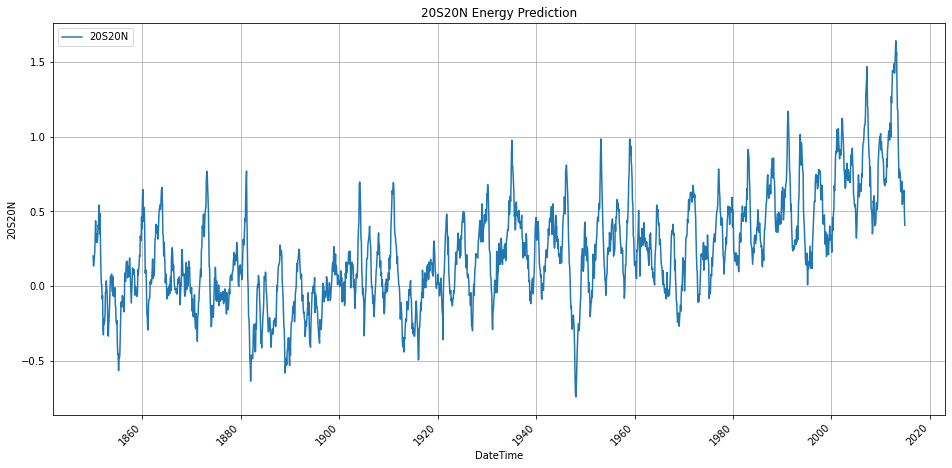

In [5]:
#plot
plot_full(plots_path,data,'20S20N')

In [6]:
data.shape

(1980, 1)

In [7]:
scaler = MinMaxScaler()
feature = '20S20N'
data[feature] = scaler.fit_transform(data)

In [8]:
#split the datasets
copied_data = data.copy().values
copied_data

array([[0.3955969 ],
       [0.3676167 ],
       [0.37847776],
       ...,
       [0.58026299],
       [0.51690792],
       [0.48181329]])

In [9]:
# n_steps = 5
# X, y = split_sequence_uni_step(copied_data,n_steps)
# step = "SingleStep"
# multi_step = False

In [10]:
n_steps = 5
multi_step = False
if multi_step:
    X, y = split_sequence_multi_step(copied_data, seq_length,output_size)
    step = 'Multistep'
else:
    X, y = split_sequence_uni_step(copied_data,n_steps)
    step = "SingleStep"

In [11]:
train_split =0.8
test_split = 0.2
batch_size =128
train_loader, val_loader, test_loader = data_loader(X, y, train_split,test_split,batch_size)

In [12]:
#lists
train_losses, val_losses = list(), list()
val_maes, val_mses, val_rmses, val_mapes, val_mpes, val_r2s = list(), list(), list(), list(), list(), list()
test_maes, test_mses, test_rmses, test_mapes, test_mpes, test_r2s = list(), list(), list(), list(), list(), list()
pred_tests, labels = list(), list()

# Constants #
best_val_loss = 100
best_val_improv = 0

In [13]:
model = 'dnn'
seq_length = 5
hidden_size = 10
output_size = 1
model = DNN(seq_length, hidden_size, output_size).to(device)

#loss Function
criterion = torch.nn.MSELoss()

#Optimizer
lr = 1e-3
lr_scheduler = 'cosine' #['step', 'plateau', 'cosine'])
optim = torch.optim.Adam(model.parameters(), lr, betas=(0.5,0.999))
optim_scheduler = get_lr_scheduler(lr_scheduler, optim)

Training DNN using SingleStep started with total epochs of 200.
Epoch [10/200]
Train Loss 0.0529
val Loss 0.1054
MAE 0.3126
MSE 0.1054
RMSE 0.3211
MPE 59.9885
MAPE 59.9885
R^2 -13.0743
Best model is saved!

Epoch [20/200]
Train Loss 0.0387
val Loss 0.0818
MAE 0.2704
MSE 0.0818
RMSE 0.2800
MPE 51.6365
MAPE 51.6365
R^2 -9.9321
Best model is saved!

Epoch [30/200]
Train Loss 0.0281
val Loss 0.0602
MAE 0.2178
MSE 0.0602
RMSE 0.2298
MPE 41.1924
MAPE 41.2450
R^2 -7.0400
Best model is saved!

Epoch [40/200]
Train Loss 0.0226
val Loss 0.0483
MAE 0.1871
MSE 0.0483
RMSE 0.2004
MPE 35.0284
MAPE 35.2089
R^2 -5.4535
Best model is saved!

Epoch [50/200]
Train Loss 0.0192
val Loss 0.0406
MAE 0.1659
MSE 0.0406
RMSE 0.1800
MPE 30.6870
MAPE 31.0730
R^2 -4.4208
Best model is saved!

Epoch [60/200]
Train Loss 0.0169
val Loss 0.0354
MAE 0.1514
MSE 0.0354
RMSE 0.1660
MPE 27.7208
MAPE 28.2584
R^2 -3.7231
Best model is saved!

Epoch [70/200]
Train Loss 0.0152
val Loss 0.0315
MAE 0.1405
MSE 0.0315
RMSE 0.1553


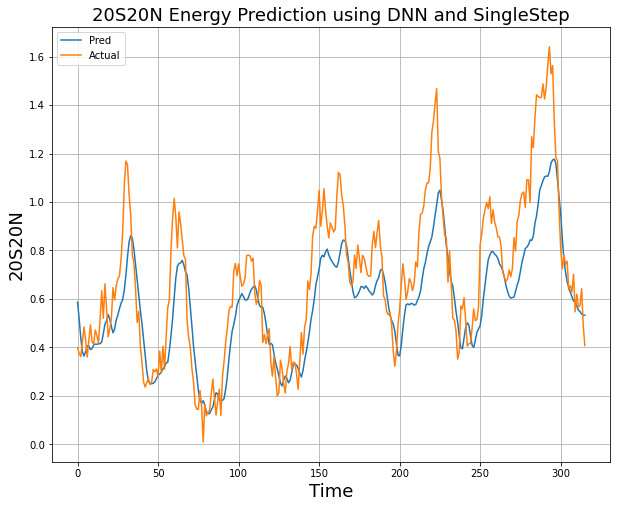

In [14]:
#Train and validation
num_epochs = 200
print_every = 10
time_plot = 500
print("Training {} using {} started with total epochs of {}.".format(model.__class__.__name__, step, num_epochs))

for epoch in range(num_epochs):
    for i, (data, label) in enumerate(train_loader):
        
        #prepare data
        data = data.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.float32)
        
        #forward data
        pred = model(data)
        
        #calculate Loss
        train_loss = criterion(pred, label)
        
        #initialize optimizer, back propagation and update
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        
        # Add item to Lists #
        train_losses.append(train_loss.item())
    
    #print statistics
    if(epoch+1) % print_every == 0:
        print("Epoch [{}/{}]".format(epoch+1, num_epochs))
        print("Train Loss {:.4f}".format(np.average(train_losses)))
        
    #Learning Rate Scheduler
    optim_scheduler.step()
    
    #validation
    with torch.no_grad():
        for i, (data,label) in enumerate(val_loader):
            
            #prepare data
            data = data.to(device, dtype =torch.float32)
            label = label.to(device, dtype=torch.float32)
            
            #forward data
            pred_val = model(data)
            
            #claculate Loss
            val_loss = criterion(pred_val, label)
            
            if multi_step:
                pred_val = np.mean(pred_val.detach().cpu().numpy(), axis=1)
                label = np.mean(label.detach().cpu().numpy(), axis=1)
            else:
                pred_val, label = pred_val.cpu(), label.cpu()
                
            #calculate Metrics
            val_mae = mean_absolute_error(label, pred_val)
            val_mse = mean_squared_error(label, pred_val, squared=True)
            val_rmse = mean_squared_error(label, pred_val, squared=False)
            val_mpe = mean_percentage_error(label, pred_val)
            val_mape = mean_absolute_percentage_error(label, pred_val)
            val_r2 = r2_score(label, pred_val)
            
            #add item to lists
            val_losses.append(val_loss.item())
            val_maes.append(val_mae.item())
            val_mses.append(val_mse.item())
            val_rmses.append(val_rmse.item())
            val_mpes.append(val_mpe.item())
            val_mapes.append(val_mape.item())
            val_r2s.append(val_r2.item())
            
        if(epoch+1) % print_every == 0:
            #print the statistics
            print("val Loss {:.4f}".format(np.average(val_losses)))
            print("MAE {:.4f}".format(np.average(val_maes)))
            print("MSE {:.4f}".format(np.average(val_mses)))
            print("RMSE {:.4f}".format(np.average(val_rmses)))
            print("MPE {:.4f}".format(np.average(val_mpes)))
            print("MAPE {:.4f}".format(np.average(val_mapes)))
            print("R^2 {:.4f}".format(np.average(val_r2s)))
            
            #save the model only if validation loss decreased
            curr_val_loss = np.average(val_losses)
            
            if curr_val_loss < best_val_loss:
                best_val_loss = min(curr_val_loss, best_val_loss)
                torch.save(model.state_dict(), os.path.join(weights_path, 'BEST_{}_using_{}.pkl'.format(model.__class__.__name__, step)))
                
                print("Best model is saved!\n")
                best_val_improv = 0
                
            elif curr_val_loss >= best_val_loss:
                best_val_improv += 1
                print("Best Validation has not improved for {} epochs.\n".format(best_val_improv))

#****Test the model
# Load the Model Weight #
model.load_state_dict(torch.load(os.path.join(weights_path, 'BEST_{}_using_{}.pkl'.format(model.__class__.__name__, step))))

with torch.no_grad():
    for i, (data, label) in enumerate(test_loader):
        
        #prepare data
        data = data.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.float32)
        
        #forward data
        pred_test = model(data)
        
        #convert to original value range
        pred_test, label = pred_test.detach().cpu().numpy(), label.detach().cpu().numpy()

        pred_test = scaler.inverse_transform(pred_test)
        label = scaler.inverse_transform(label)
        
        if multi_step:
            pred_test = np.mean(pred_test, axis=1)
            label = np.mean(label, axis=1)
            
        pred_tests += pred_test.tolist()
        labels += label.tolist()
        
        #calculate loss
        test_mae = mean_absolute_error(label, pred_test)
        test_mse = mean_squared_error(label, pred_test, squared=True)
        test_rmse = mean_squared_error(label, pred_test, squared=False)
        test_mpe = mean_percentage_error(label, pred_test)
        test_mape = mean_absolute_percentage_error(label, pred_test)
        test_r2 = r2_score(label, pred_test)
        
        #add item to list
        test_maes.append(test_mae.item())
        test_mses.append(test_mse.item())
        test_rmses.append(test_rmse.item())
        test_mpes.append(test_mpe.item())
        test_mapes.append(test_mape.item())
        test_r2s.append(test_r2.item())
        
    # Print Statistics #
    print("Test {} using {}".format(model.__class__.__name__, step))
    print(" MAE : {:.4f}".format(np.average(test_maes)))
    print(" MSE : {:.4f}".format(np.average(test_mses)))
    print("RMSE : {:.4f}".format(np.average(test_rmses)))
    print(" MPE : {:.4f}".format(np.average(test_mpes)))
    print("MAPE : {:.4f}".format(np.average(test_mapes)))
    print(" R^2 : {:.4f}".format(np.average(test_r2s)))
    
        
    #plot figure
    plot_pred_test(pred_tests[:time_plot], labels[:time_plot], plots_path, feature, model, step)

    # Save Numpy files #
    np.save(os.path.join(numpy_path, '{}_using_{}_TestSet.npy'.format(model.__class__.__name__, step)), np.asarray(pred_tests))
    np.save(os.path.join(numpy_path, 'TestSet_using_{}.npy'.format(step)), np.asarray(labels))

        
        

In [15]:
print(data.shape, label.shape)

torch.Size([60, 5, 1]) (60, 1)
